## Data Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import shutil

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_csv_path = '/content/drive/My Drive/Meat/train/_classes.csv'
valid_csv_path = '/content/drive/My Drive/Meat/valid/_classes.csv'

In [6]:
train_data = pd.read_csv(train_csv_path)
valid_data = pd.read_csv(valid_csv_path)

train_dir = '/content/drive/My Drive/Meat/train/'
valid_dir = '/content/drive/My Drive/Meat/valid/'
print("Train Data Columns:", train_data.columns)
print("Valid Data Columns:", valid_data.columns)

train_data['filename'] = train_data['filename'].apply(lambda x: os.path.join(train_dir, x))
valid_data['filename'] = valid_data['filename'].apply(lambda x: os.path.join(valid_dir, x))
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()

Train Data Columns: Index(['filename', ' Fresh', ' Half-Fresh', ' Spoiled'], dtype='object')
Valid Data Columns: Index(['filename', ' Fresh', ' Half-Fresh', ' Spoiled'], dtype='object')


In [14]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()

In [15]:
# Image data generators for data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    class_mode='raw',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True
)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    class_mode='raw',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False # this needs to set to false otherwise the predictions will be made for the wrong indexes
)



Found 1815 validated image filenames.
Found 451 validated image filenames.


In [16]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



In [11]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {valid_generator.samples}")

Training samples: 1815
Validation samples: 451


In [17]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=20)

Epoch 1/20
57/57 [==============================] - 607s 11s/step - loss: 0.7178 - accuracy: 0.6893 - val_loss: 0.2437 - val_accuracy: 0.9490
Epoch 2/20
57/57 [==============================] - 26s 453ms/step - loss: 0.3294 - accuracy: 0.8650 - val_loss: 0.1664 - val_accuracy: 0.9468
Epoch 3/20
57/57 [==============================] - 26s 458ms/step - loss: 0.2704 - accuracy: 0.8937 - val_loss: 0.1355 - val_accuracy: 0.9579
Epoch 4/20
57/57 [==============================] - 26s 458ms/step - loss: 0.2324 - accuracy: 0.9069 - val_loss: 0.1180 - val_accuracy: 0.9601
Epoch 5/20
57/57 [==============================] - 26s 462ms/step - loss: 0.2055 - accuracy: 0.9284 - val_loss: 0.1011 - val_accuracy: 0.9667
Epoch 6/20
57/57 [==============================] - 26s 457ms/step - loss: 0.1987 - accuracy: 0.9240 - val_loss: 0.0909 - val_accuracy: 0.9734
Epoch 7/20
57/57 [==============================] - 27s 465ms/step - loss: 0.1748 - accuracy: 0.9284 - val_loss: 0.0856 - val_accuracy: 0.9712


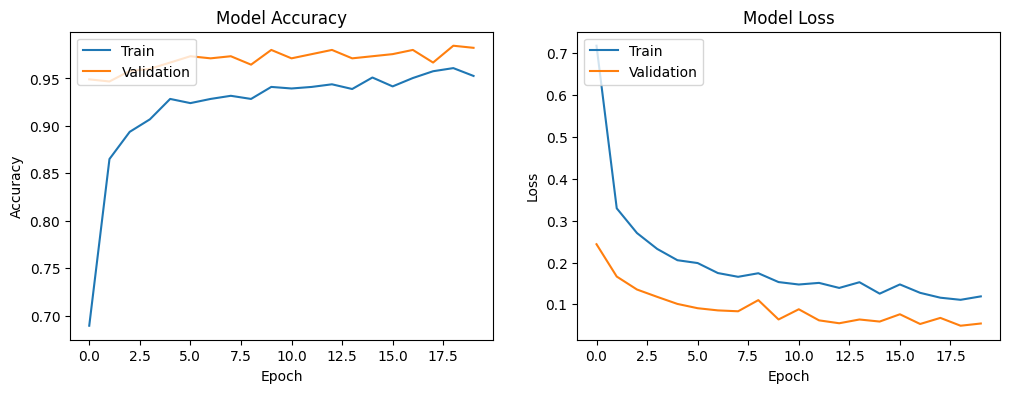

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

15/15 [==============================] - 2s 137ms/step


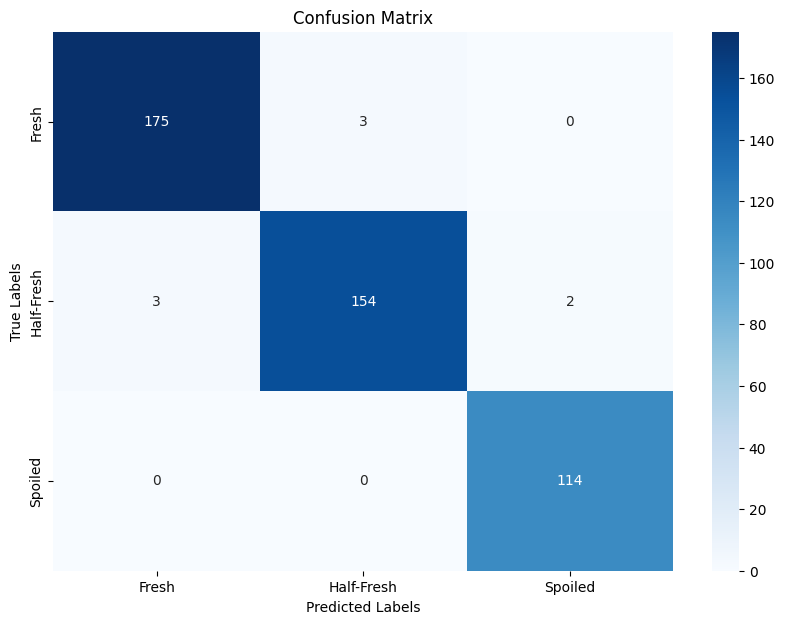

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_labels = ['Fresh', 'Half-Fresh', 'Spoiled']

valid_predictions = model.predict(valid_generator)

valid_pred_classes = np.argmax(valid_predictions, axis=1)

true_labels = valid_data[['Fresh', 'Half-Fresh', 'Spoiled']].values
true_classes = np.argmax(true_labels, axis=1)

conf_matrix = confusion_matrix(true_classes, valid_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [20]:
class_report = classification_report(true_classes, valid_pred_classes, target_names=class_labels)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

       Fresh       0.98      0.98      0.98       178
  Half-Fresh       0.98      0.97      0.97       159
     Spoiled       0.98      1.00      0.99       114

    accuracy                           0.98       451
   macro avg       0.98      0.98      0.98       451
weighted avg       0.98      0.98      0.98       451

